# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

If you completed the first term of this program, you will be familiar with the first part of this project, from the unsupervised learning project. The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

In [3]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.decomposition import PCA

from sklearn.impute import SimpleImputer
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler

from sklearn.cluster import KMeans

# supervied learning
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier


from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

from sklearn.calibration import calibration_curve

from sklearn.model_selection import train_test_split


# magic word for producing visualizations in notebook
%matplotlib inline

## Part 0: Get to Know the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

In [2]:
# load in the data
azdias = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_AZDIAS_052018.csv', sep=';', low_memory=False)
customers = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_CUSTOMERS_052018.csv', sep=';', low_memory=False)

At first, I will do some basic explorative data analysis to get a overview of the datasets. As a part of this I show the first few lines of the dataset as well as the dimensions.

In [3]:
(azdias.shape)

(891221, 366)

In [4]:
azdias.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,910215,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,1,2
1,910220,-1,9.0,0.0,NaN,NaN,NaN,NaN,21.0,11.0,...,4.0,8.0,11.0,10.0,3.0,9.0,4.0,5,2,1
2,910225,-1,9.0,17.0,NaN,NaN,NaN,NaN,17.0,10.0,...,2.0,9.0,9.0,6.0,3.0,9.0,2.0,5,2,3
3,910226,2,1.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,...,0.0,7.0,10.0,11.0,NaN,9.0,7.0,3,2,4
4,910241,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,3.0,...,2.0,3.0,5.0,4.0,2.0,9.0,3.0,4,1,3


In [5]:
(customers.shape)

(191652, 369)

In [6]:
customers.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,PRODUCT_GROUP,CUSTOMER_GROUP,ONLINE_PURCHASE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,9626,2,1.0,10.0,NaN,NaN,NaN,NaN,10.0,1.0,...,2.0,6.0,9.0,7.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,1,4
1,9628,-1,9.0,11.0,NaN,NaN,NaN,NaN,NaN,NaN,...,3.0,0.0,9.0,NaN,3,FOOD,SINGLE_BUYER,0,1,4
2,143872,-1,1.0,6.0,NaN,NaN,NaN,NaN,0.0,1.0,...,11.0,6.0,9.0,2.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,2,4
3,143873,1,1.0,8.0,NaN,NaN,NaN,NaN,8.0,0.0,...,2.0,NaN,9.0,7.0,1,COSMETIC,MULTI_BUYER,0,1,4
4,143874,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,7.0,...,4.0,2.0,9.0,3.0,1,FOOD,MULTI_BUYER,0,1,3


The customers data set has 3 more columns:

In [7]:
customers_columns = {elem for elem in customers.columns}
azdias_columns = {elem for elem in azdias.columns}

customers_columns.difference(azdias_columns)

{'CUSTOMER_GROUP', 'ONLINE_PURCHASE', 'PRODUCT_GROUP'}

Removing this columns from the customers data set to receive the same dimensions. Also drop column LNR as it is an index. 

In [8]:
customers.drop(['CUSTOMER_GROUP', 'ONLINE_PURCHASE', 'PRODUCT_GROUP', 'LNR'], axis=1, inplace = True)
azdias.drop(['LNR'], axis=1, inplace = True)

Using the infomartion provided by the DIAS Attributes excel file.

In [9]:
attributes_metdata = pd.read_excel('DIAS Attributes - Values 2017.xlsx')
attributes_metdata.drop(['Unnamed: 0'], axis = 1, inplace = True)
attributes_metdata.columns = ["Attribute", "Description", "Value", "Meaning"]
attributes_metdata.head(n=20)

,Attribute,Description,Value,Meaning
0,AGER_TYP,best-ager typology,-1,unknown
1,NaN,NaN,0,no classification possible
2,NaN,NaN,1,passive elderly
3,NaN,NaN,2,cultural elderly
4,NaN,NaN,3,experience-driven elderly
5,ALTERSKATEGORIE_GROB,age classification through prename analysis,"-1, 0",unknown
6,NaN,NaN,1,< 30 years
7,NaN,NaN,2,30 - 45 years
8,NaN,NaN,3,46 - 60 years
9,NaN,NaN,4,> 60 years


Check how many attributes are given in that file. I subtract 1 because of the NaN value. 

In [10]:
len(attributes_metdata['Attribute'].unique()) - 1

314

So there are informations only for fewer attributes than in the data set. I decide to use only those attributes, that are contained in the DIAS Attributes file:

In [11]:
attributes_columns = {elem for elem in attributes_metdata['Attribute']}
columns_to_keep = azdias_columns.intersection(attributes_columns)
columns_to_keep = [elem for elem in columns_to_keep]

azdias = azdias[columns_to_keep]
customers = customers[columns_to_keep]

I filter also all attributes that end with "GROB" because there is no more information in these variables than in the corresponding "FEIN" variables. 

In [12]:
for col in azdias.columns:
    if "GROB" in col:
        azdias.drop([col], axis=1, inplace = True)
        customers.drop([col], axis=1, inplace = True)

In [13]:
azdias.shape

(891221, 268)

In [14]:
customers.shape

(191652, 268)

Now I want do extract the values with the meaning "unknown" or for example "no score calculated" from the DIAS Attributes file and set the corresponding values in the data frame to NaN. With this procedure I can a more realistic 

In [15]:
attributes_metdata['Attribute'] = attributes_metdata['Attribute'].fillna(method='ffill')
mask =  ~attributes_metdata['Meaning'].isnull() & attributes_metdata['Meaning'].str.contains("unknown") 
attributes_metdata[mask]

,Attribute,Description,Value,Meaning
0,AGER_TYP,best-ager typology,-1,unknown
5,ALTERSKATEGORIE_GROB,age classification through prename analysis,"-1, 0",unknown
11,ALTER_HH,main age within the household,0,unknown / no main age detectable
33,ANREDE_KZ,gender,"-1, 0",unknown
40,BALLRAUM,distance to next urban centre,-1,unknown
48,BIP_FLAG,business-flag indicating companies in the buil...,-1,unknown
51,CAMEO_DEUG_2015,CAMEO classification 2015 - Uppergroup,-1,unknown
105,CAMEO_DEUINTL_2015,CAMEO classification 2015 - international typo...,-1,unknown
131,CJT_GESAMTTYP,customer journey typology,0,unknown
391,D19_KK_KUNDENTYP,consumption movement in the last 12 months,-1,unknown


Extracting the values for the unkown meaning

In [16]:
df_missing = attributes_metdata[mask]
missing_dict = {}

for attr in df_missing['Attribute']:
    list_curr = []
    
    row = df_missing[df_missing['Attribute'] == attr]
    value = row['Value'].values[0]
    
    if type(value) is int:
        list_curr.append(value)
    else:       
        list_curr = [int(elem) for elem in value.split(',')]
        
    missing_dict[attr] = list_curr
    
missing_dict

{'AGER_TYP': [-1],
 'ALTERSKATEGORIE_GROB': [-1, 0],
 'ALTER_HH': [0],
 'ANREDE_KZ': [-1, 0],
 'BALLRAUM': [-1],
 'BIP_FLAG': [-1],
 'CAMEO_DEUG_2015': [-1],
 'CAMEO_DEUINTL_2015': [-1],
 'CJT_GESAMTTYP': [0],
 'D19_KK_KUNDENTYP': [-1],
 'EWDICHTE': [-1],
 'FINANZTYP': [-1],
 'FINANZ_ANLEGER': [-1],
 'FINANZ_HAUSBAUER': [-1],
 'FINANZ_MINIMALIST': [-1],
 'FINANZ_SPARER': [-1],
 'FINANZ_UNAUFFAELLIGER': [-1],
 'FINANZ_VORSORGER': [-1],
 'GEBAEUDETYP': [-1, 0],
 'GEOSCORE_KLS7': [-1, 0],
 'HAUSHALTSSTRUKTUR': [-1, 0],
 'HEALTH_TYP': [-1],
 'HH_EINKOMMEN_SCORE': [-1, 0],
 'INNENSTADT': [-1],
 'KBA05_ALTER1': [-1, 9],
 'KBA05_ALTER2': [-1, 9],
 'KBA05_ALTER3': [-1, 9],
 'KBA05_ALTER4': [-1, 9],
 'KBA05_ANHANG': [-1, 9],
 'KBA05_ANTG1': [-1],
 'KBA05_ANTG2': [-1],
 'KBA05_ANTG3': [-1],
 'KBA05_ANTG4': [-1],
 'KBA05_AUTOQUOT': [-1, 9],
 'KBA05_BAUMAX': [-1, 0],
 'KBA05_CCM1': [-1, 9],
 'KBA05_CCM2': [-1, 9],
 'KBA05_CCM3': [-1, 9],
 'KBA05_CCM4': [-1, 9],
 'KBA05_DIESEL': [-1, 9],
 'KBA05_FR

Setting all missing values to NaN in both datasets.

In [17]:
for attr in azdias.columns:
    if attr in missing_dict.keys():
        azdias[attr].replace(missing_dict[attr], np.nan, inplace=True)
        customers[attr].replace(missing_dict[attr], np.nan, inplace=True)

Investiogation of missing values

In [18]:
N, p = azdias.shape
predictors_null = azdias.isnull().sum()
predictors_null_relative_azdias = predictors_null / N

N, p = customers.shape
predictors_null = customers.isnull().sum()
predictors_null_relative_customers = predictors_null / N

Sorting ascending relative missing values to obtain only the highes missing rates. I will plot only those, becaus all the data would not fit into a plot. 

In [19]:
df_missing = pd.DataFrame([predictors_null_relative_azdias, predictors_null_relative_customers]).T

df_missing.columns = ["azdias", "customers"]
df_missing['Attribute'] = df_missing.index
df_missing_plot = df_missing.sort_values(by=['azdias'], ascending=False)[0:15]
df_missing_plot = pd.melt(df_missing_plot, id_vars=['Attribute'], value_vars=[ 'azdias', 'customers'])
df_missing_plot.head(n=20)

,Attribute,variable,value
0,TITEL_KZ,azdias,0.997576
1,AGER_TYP,azdias,0.760196
2,KBA05_BAUMAX,azdias,0.534687
3,ALTER_HH,azdias,0.348137
4,D19_VERSAND_ONLINE_QUOTE_12,azdias,0.288495
5,D19_KONSUMTYP,azdias,0.288495
6,D19_GESAMT_ONLINE_QUOTE_12,azdias,0.288495
7,D19_BANKEN_ONLINE_QUOTE_12,azdias,0.288495
8,KKK,azdias,0.177357
9,REGIOTYP,azdias,0.177357


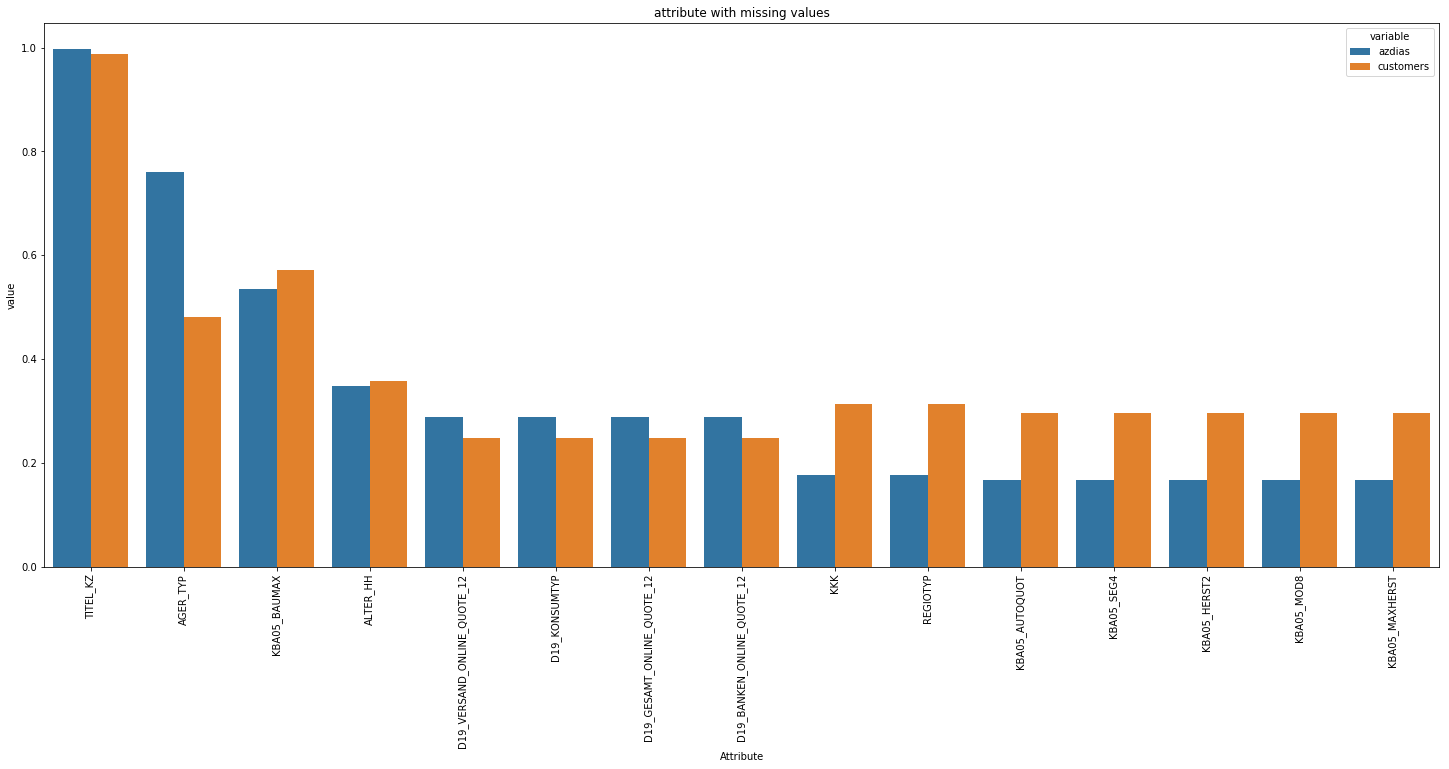

In [20]:
#sns.set(style="whitegrid")
fig = plt.figure(figsize=(25,10))
ax = sns.barplot(x="Attribute", y="value", hue="variable", ci=None, data=df_missing_plot)
plt.xticks(rotation=90)
ax.set_title("attribute with missing values")
fig.savefig('nas.png', bbox_inches='tight')

Selecting only those variables where the percentage of missing values is smaller than 5 %:

In [21]:
percentage_of_nas_lead_to_dropping = 0.10
df_missing = df_missing.sort_values(by=['azdias'], ascending=False)
predictors_to_keep = df_missing[df_missing['azdias'] < percentage_of_nas_lead_to_dropping].index
azdias = azdias[predictors_to_keep]
customers = customers[predictors_to_keep]

In [22]:
azdias.shape

(891221, 59)

In [23]:
customers.shape

(191652, 59)

I identified all categorial variables myself with the help of the Attributes excel file. I will tranfrom every of these variables into the type cateogial.

In [24]:
categorial_variables = ['AGER_TYP', 'ANREDE_KZ', 'BIP_FLAG', 'CAMEO_DEUG_2015', 'CAMEO_DEU_2015', 'CAMEO_DEUINTL_2015',
'CJT_GESAMTTYP', 'D19_BANKEN_DATUM', 'D19_BANKEN_DIREKT_RZ', 'D19_BANKEN_GROSS_RZ', 'D19_BANKEN_OFFLINE_DATUM',
'D19_BANKEN_ONLINE_DATUM', 'D19_BANKEN_REST_RZ', 'D19_BEKLEIDUNG_GEH_RZ', 'D19_BEKLEIDUNG_REST_RZ', 
'D19_BILDUNG_RZ', 'D19_BIO_OEKO_RZ', 'D19_BUCH_RZ', 'D19_DIGIT_SERV_RZ', 'D19_DROGERIEARTIKEL_RZ', 
'D19_ENERGIE_RZ', 'D19_FREIZEIT_RZ','D19_GARTEN_RZ',
'D19_GESAMT_DATUM,'
'D19_GESAMT_OFFLINE_DATUM',
'D19_GESAMT_ONLINE_DATUM',
'D19_HANDWERK_RZ',
'D19_HAUS_DEKO_RZ',
'D19_KINDERARTIKEL,RZ',
'D19_KONSUMTYP',
'D19_KK_KUNDENTYP',
'D19_KOSMETIK_RZ',
'D19_LEBENSMITTEL_RZ',
'D19_LOTTO_RZ',
'D19_NAHRUNGSERGAENZUNG_RZ',
'D19_RATGEBER_RZ',
'D19_REISEN_RZ',
'D19_SAMMELARTIKEL_RZ',
'D19_SCHUHE_RZ',
'D19_SONSTIGE_RZ',
'D19_TECHNIK_RZ',
'D19_TELKO_DATUM',
'D19_TELKO_MOBILE_RZ'
'D19_TELKO_OFFLINE_DATUM',
'D19_TELKO_ONLINE_DATUM',
'D19_TELKO_REST_RZ',
'D19_TIERARTIKEL_RZ',
'D19_VERSAND_DATUM',
'D19_VERSAND_OFFLINE_DATUM',
'D19_VERSAND_ONLINE_DATUM',
'D19_VERSAND_REST_RZ',
'D19_VERSICHERUNGEN_RZ',
'D19_VOLLSORTIMENT_RZ',
'D19_WEIN_FEINKOST_RZ',
'GEBAEUDETYP',
'GEBAEUDETYP_RASTER',
'GFK_URLAUBERTYP',
'GREEN_AVANTGARDE',
'HAUSHALTSSTRUKTUR',
'HEALTH_TYP',
'KBA05_HERSTTEMP'
'KBA05_MODTEMP',
'KBA05_MAXHERST',
'LP_FAMILIE_FEIN',
'LP_FAMILIE_GROB',
'NATIONALITAET_KZ',
'OST_WEST_KZ',
'SHOPPER_TYP',
'SOHO_FLAG',
'TITEL_KZ',
'VERS_TYP',
'ZABEOTYP']
    
for attr in customers.columns:
    if attr in categorial_variables or (customers.dtypes[attr] != 'float64' and customers.dtypes[attr] != 'int64'):
        customers[attr] = customers[attr].astype('category')
        azdias[attr] = azdias[attr].astype('category')

Now I can impute missing values. For categorial variables I use the most common value and for numerical i impute with k-nearest neighbours with k = 5. I also convert the categorial variables into dummies. 

In [25]:
df_category = customers.select_dtypes(include='category')
imp = SimpleImputer(strategy="most_frequent")
imp.fit(df_category)
df_category = pd.DataFrame(imp.transform(df_category), columns=df_category.columns)
df_category = df_category.astype('category')
df_category = pd.get_dummies(df_category)

df_float = customers.select_dtypes(include='float64')
#imp = KNNImputer(n_neighbors=5, weights="uniform")
imp = SimpleImputer(missing_values=np.nan, strategy='mean')
imp.fit(df_float)
df_float = pd.DataFrame(imp.transform(df_float), columns=df_float.columns)

customers = pd.concat([df_category, df_float], axis=1)


df_category = azdias.select_dtypes(include='category')
imp = SimpleImputer(strategy="most_frequent")
imp.fit(df_category)
df_category = pd.DataFrame(imp.transform(df_category), columns=df_category.columns)
df_category = df_category.astype('category')
df_category = pd.get_dummies(df_category)

   
df_float = azdias.select_dtypes(include='float64')
#imp = KNNImputer(n_neighbors=5, weights="uniform")
imp = SimpleImputer(missing_values=np.nan, strategy='mean')
imp.fit(df_float)
df_float = pd.DataFrame(imp.transform(df_float), columns=df_float.columns)

azdias = pd.concat([df_category, df_float], axis=1)

Finally scalling and standardize variables.

In [26]:
scaler_customers = StandardScaler()
scaler_customers.fit(customers)
customers = pd.DataFrame(scaler_customers.transform(customers), columns=customers.columns)
scaler_azdias = StandardScaler()
scaler_azdias.fit(azdias)
azdias = pd.DataFrame(scaler_azdias.transform(azdias), columns=azdias.columns)

In [27]:
#saving files
#customers.to_pickle("customer.pkl")
#azdias.to_pickle("azdias.pkl")


#customers=pd.read_pickle("customer.pkl")
#azdias= pd.read_pickle("azdias.pkl")

## Part 1: Customer Segmentation Report

The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

Inspection how many number of components are necessary to explain a given percentage of underlying variance of the data. 

65 components are necessary to explain 0.8 % percent of whole variance.


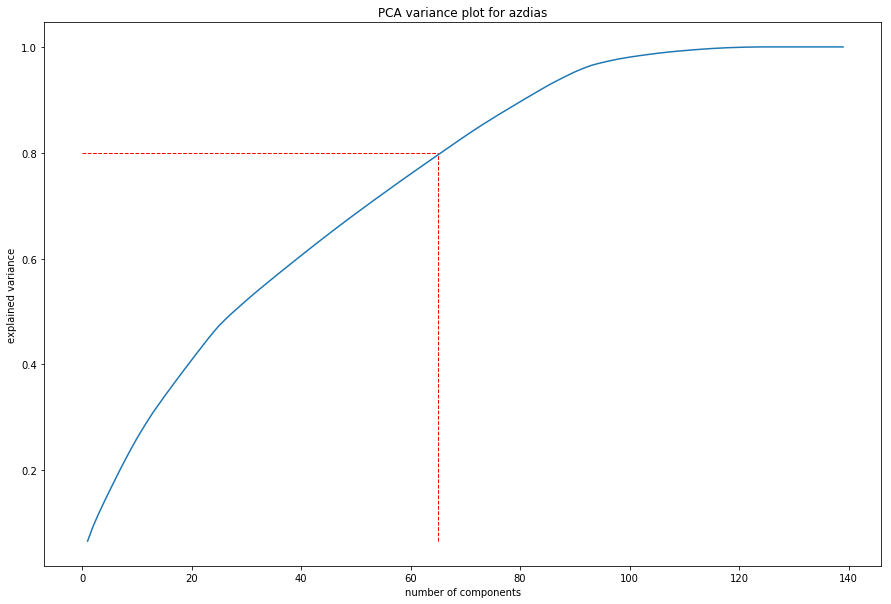

In [28]:
variance_threshold = 0.8

pca_azdias = PCA() 
azdias_pca = pca_azdias.fit_transform(azdias)
cumulative_variance = np.cumsum(pca_azdias.explained_variance_ratio_)
relevant_components = np.where(cumulative_variance>variance_threshold)[0][0]
print("{} components are necessary to explain {} % percent of whole variance.".format(relevant_components, variance_threshold))

fig = plt.figure(figsize=(15,10))
x = np.arange(0, pca_azdias.n_features_) + 1
y = np.cumsum(pca_azdias.explained_variance_ratio_)

plt.plot(x, y)
plt.vlines(x=relevant_components, ymin=pca_azdias.explained_variance_ratio_[0], ymax=variance_threshold, linewidth=1, color='r', linestyle='--')
plt.hlines(y=variance_threshold, xmin=0, xmax=relevant_components, linewidth=1, color='r', linestyle='--')
plt.xlabel('number of components')
plt.ylabel('explained variance')
plt.title('PCA variance plot for azdias')
fig.savefig('pca_azdias.png', bbox_inches='tight')

The same for the custumers dataset.

64 components are necessary to explain 0.8 % percent of whole variance.


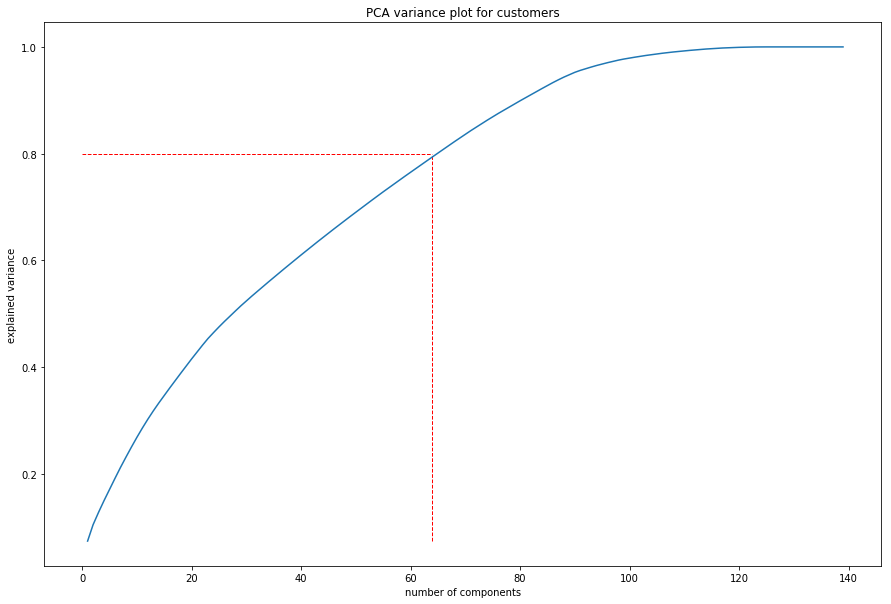

In [29]:
variance_threshold = 0.8

pca_customers = PCA() 
customers_pca = pca_customers.fit_transform(customers)
cumulative_variance = np.cumsum(pca_customers.explained_variance_ratio_)
relevant_components = np.where(cumulative_variance>variance_threshold)[0][0]
print("{} components are necessary to explain {} % percent of whole variance.".format(relevant_components, variance_threshold))

fig = plt.figure(figsize=(15,10))
x = np.arange(0, pca_customers.n_features_) + 1
y = np.cumsum(pca_customers.explained_variance_ratio_)

plt.plot(x, y)
plt.vlines(x=relevant_components, ymin=pca_customers.explained_variance_ratio_[0], ymax=variance_threshold, linewidth=1, color='r', linestyle='--')
plt.hlines(y=variance_threshold, xmin=0, xmax=relevant_components, linewidth=1, color='r', linestyle='--')
plt.xlabel('number of components')
plt.ylabel('explained variance')
plt.title('PCA variance plot for customers')
fig.savefig('pca_customers.png', bbox_inches='tight')

Now I want to inspect the composition of the compontents regarding the attributes of the dataset. I look at the first five components and the attributes with the most absolute impact with respect to that component. 

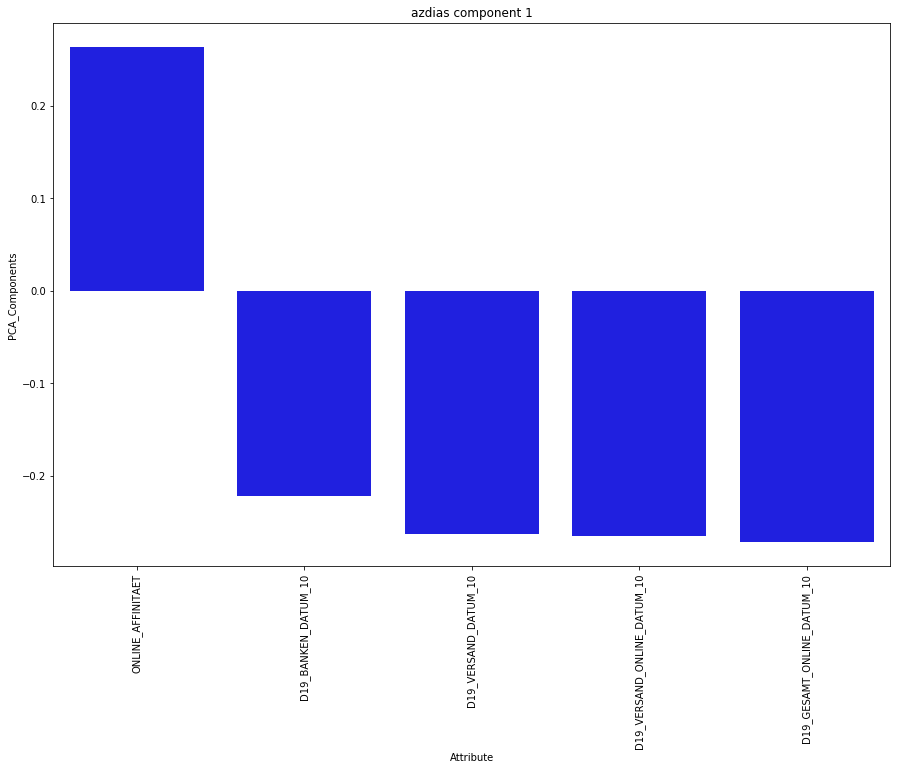

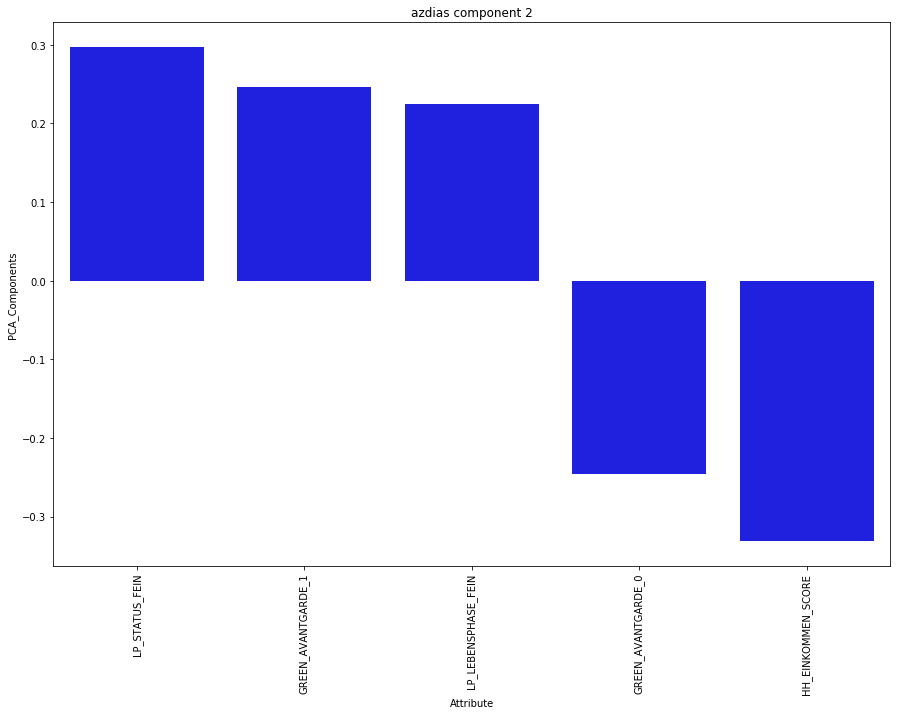

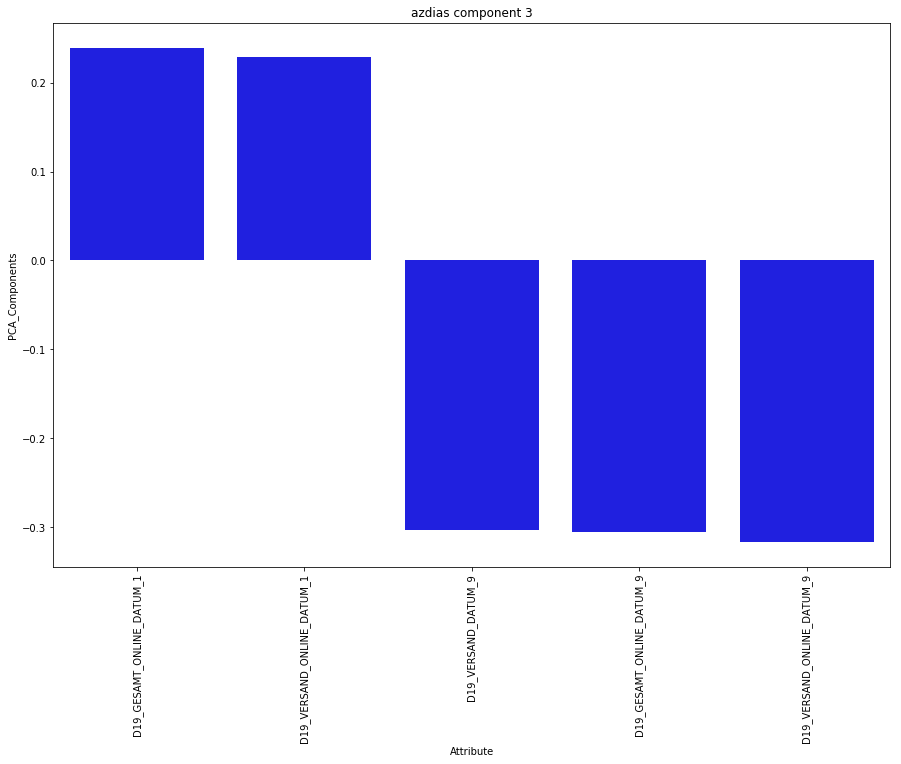

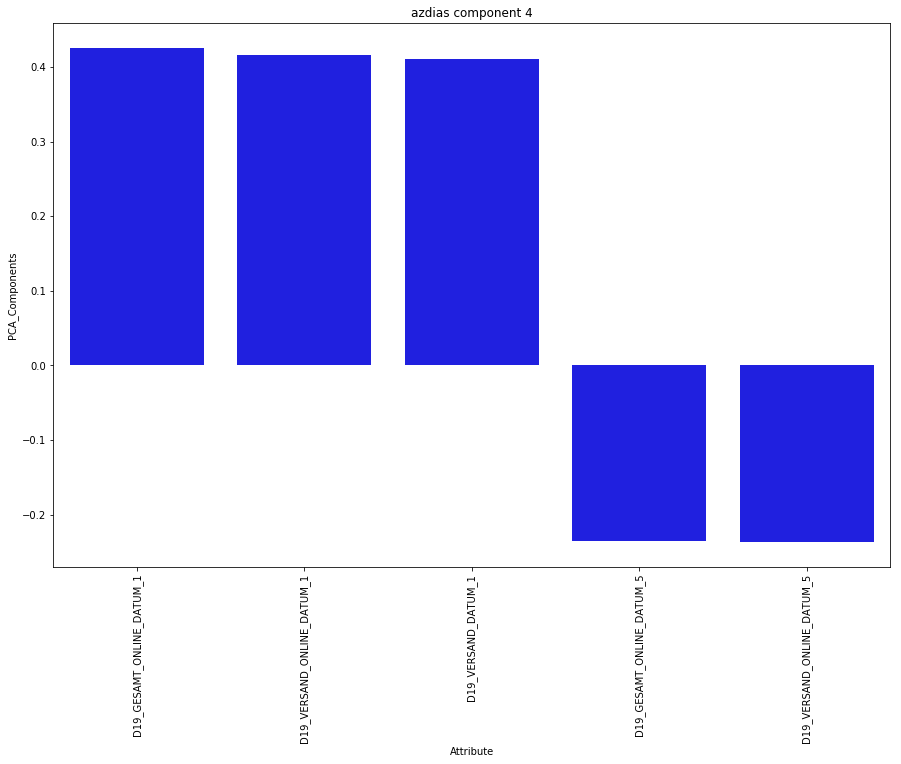

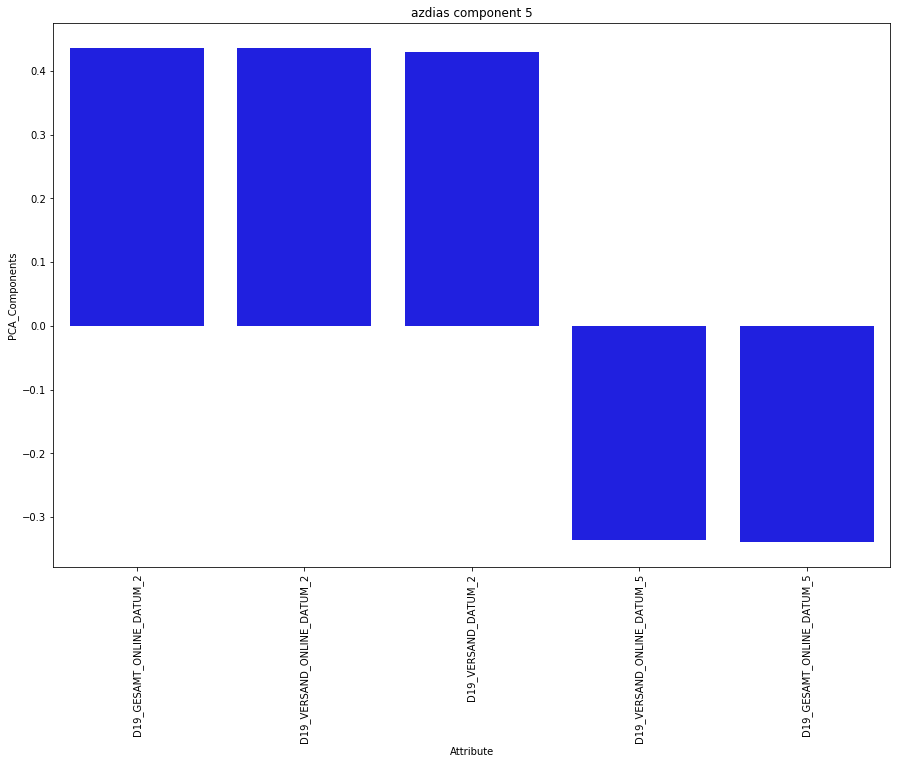

In [30]:
n_component = 5
n_attributes = 5

def plot_composition_pca(df, pca, component, name):

    data = {'PCA_Components': pca.components_[component],
           'Attribute': df.columns}
    df_component = pd.DataFrame(data)
    df_component = df_component.assign(PCA_Components_absolute=np.abs(df_component['PCA_Components']))



    df_component = df_component.sort_values(by=['PCA_Components_absolute'], ascending=False)[0:n_attributes]
    df_component = df_component.sort_values(by=['PCA_Components'], ascending=False)

    fig = plt.figure(figsize=(15,10))
    ax = sns.barplot(x="Attribute", y="PCA_Components", ci=None, data=df_component, color = "blue")
    title = "{} component {}".format(name, component+1)
    ax.set_title(title)
    plt.xticks(rotation=90)
    
    fig.savefig(title+'png', bbox_inches='tight')
    
    return df_component
    
for component in range(n_component):
    plot_composition_pca(azdias, pca_azdias, component, "azdias")

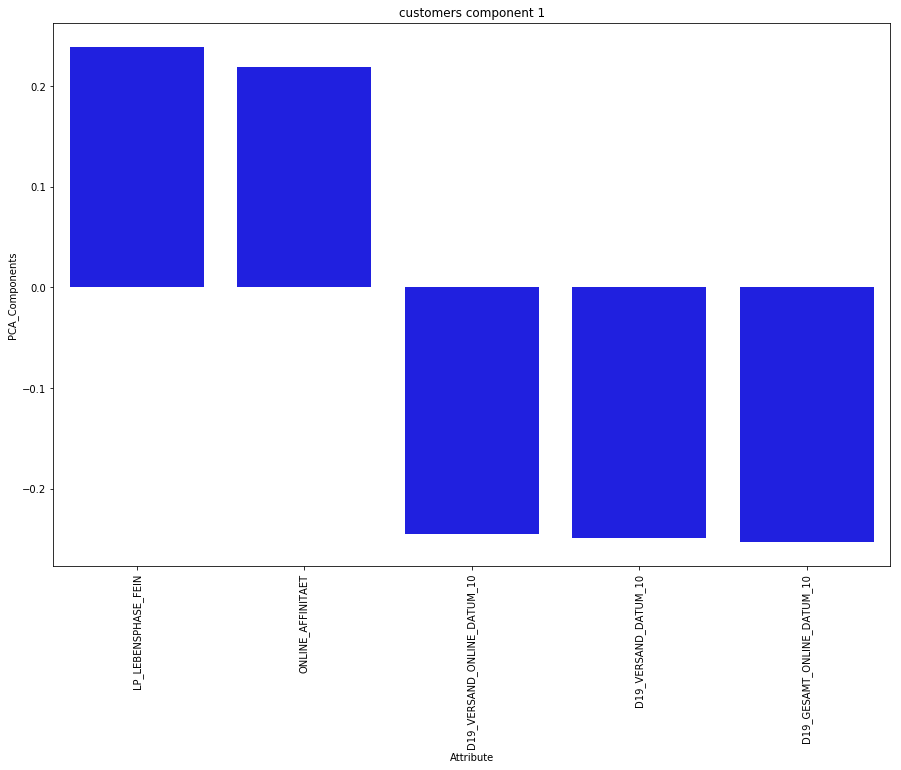

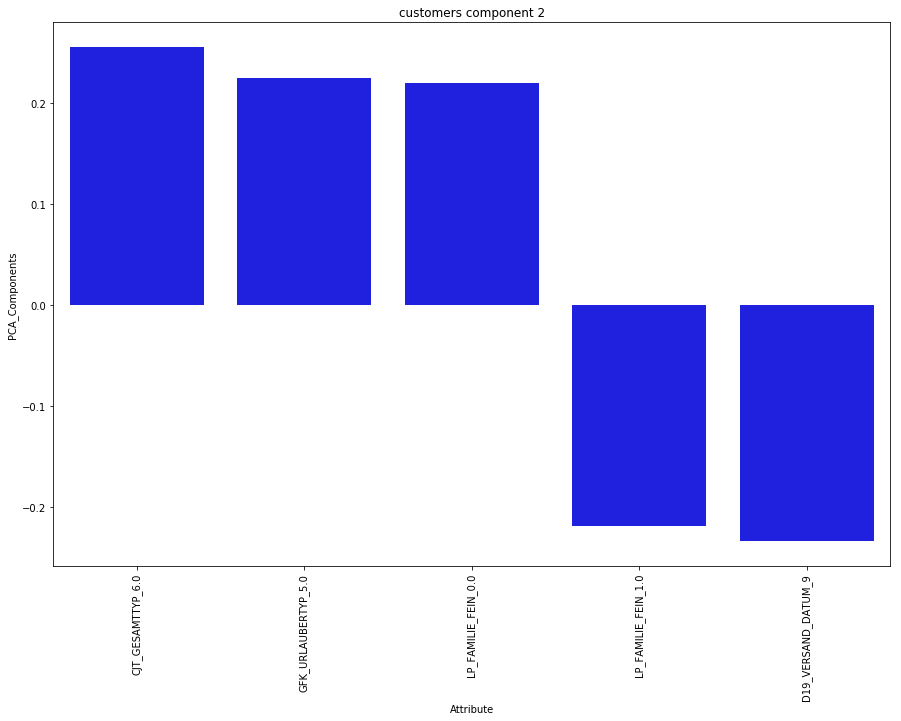

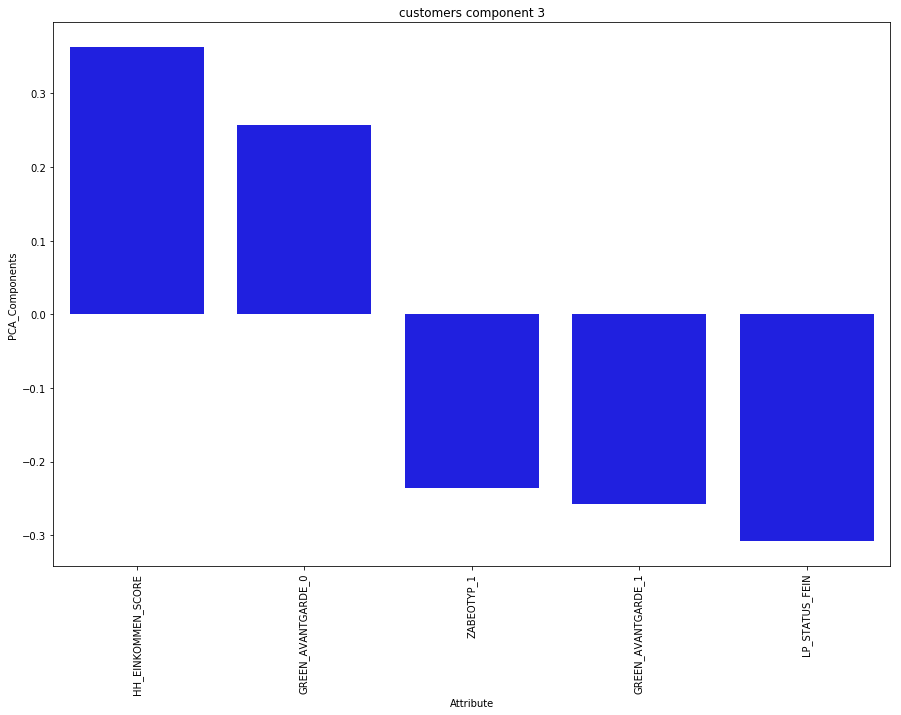

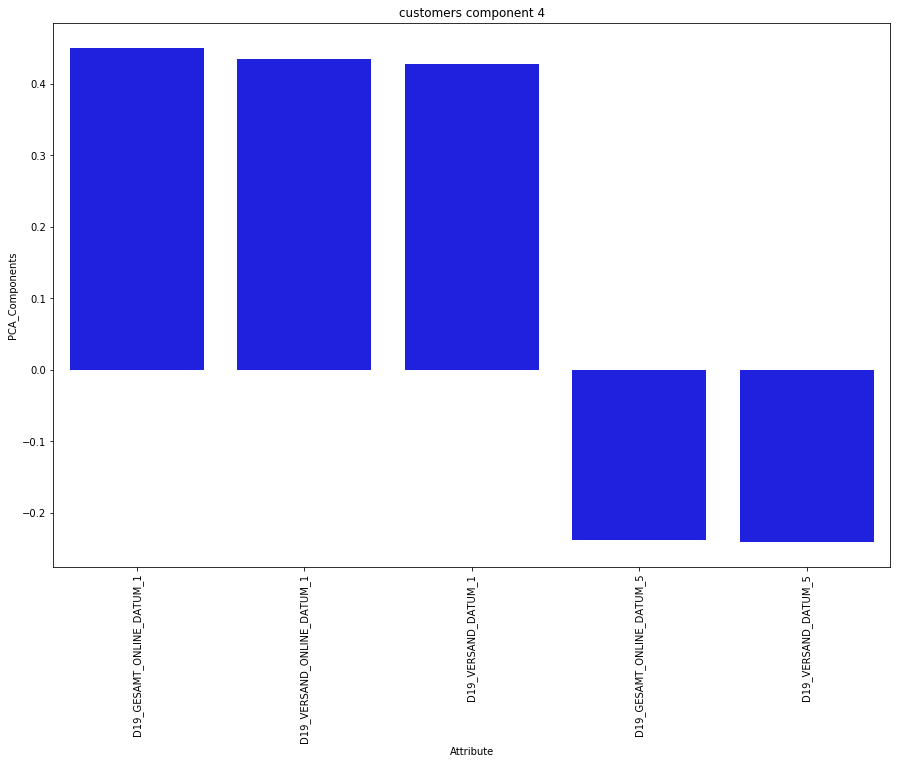

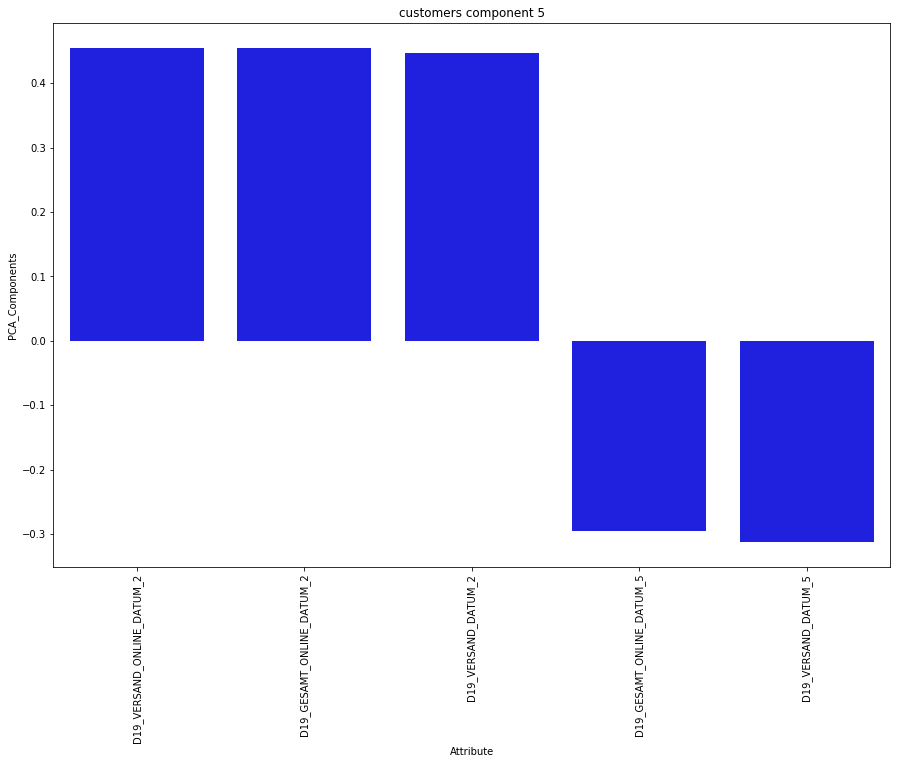

In [31]:
for component in range(n_component):
    plot_composition_pca(customers, pca_customers, component, "customers")

Now I calculate the intersect of the top five attributes of the top ten components.

In [32]:
n_components = 5
n_attributes_per_component = 5


def get_most_influencial_attributes(df, pca, n_components, n_attributes_per_component):

    top_components = []

    for component in range(0,n_components):


        data = {'PCA_Components': pca.components_[component],
               'Attribute': df.columns}
        df_component = pd.DataFrame(data)
        df_component = df_component.assign(PCA_Components_absolute=np.abs(df_component['PCA_Components']))



        df_component = df_component.sort_values(by=['PCA_Components_absolute'], ascending=False)[0:n_attributes_per_component]
        components_curr = [elem for elem in df_component['Attribute'].values.astype(str)]
        top_components += components_curr
    
    return(top_components)
    
    
top_components_azdias = get_most_influencial_attributes(azdias, pca_azdias, n_components, n_attributes_per_component)
top_components_customers = get_most_influencial_attributes(customers, pca_customers, n_components, n_attributes_per_component)


most_information_attributes = [elem for elem in set(top_components_azdias).intersection(set(top_components_customers))]

print(most_information_attributes)
len(most_information_attributes)


['D19_GESAMT_ONLINE_DATUM_5', 'GREEN_AVANTGARDE_1', 'D19_VERSAND_ONLINE_DATUM_1', 'D19_GESAMT_ONLINE_DATUM_2', 'D19_GESAMT_ONLINE_DATUM_10', 'D19_VERSAND_ONLINE_DATUM_10', 'LP_STATUS_FEIN', 'D19_VERSAND_DATUM_1', 'ONLINE_AFFINITAET', 'HH_EINKOMMEN_SCORE', 'D19_GESAMT_ONLINE_DATUM_1', 'D19_VERSAND_DATUM_10', 'D19_VERSAND_ONLINE_DATUM_2', 'D19_VERSAND_DATUM_9', 'GREEN_AVANTGARDE_0', 'D19_VERSAND_DATUM_2', 'LP_LEBENSPHASE_FEIN']


17

knn Clustering

Selectin the first X components of the PCA

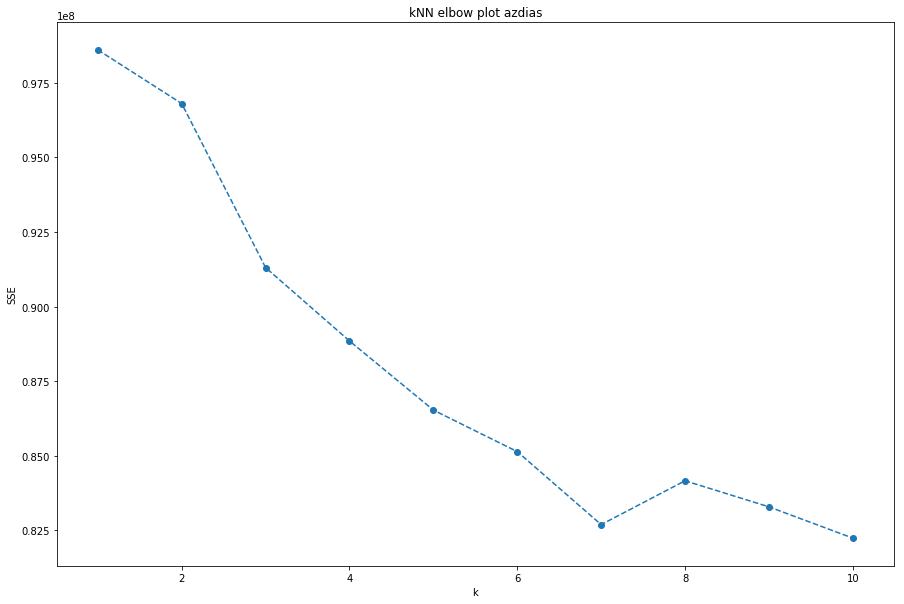

In [33]:
n_cluster = 10
n_selected_components = 65

azdias_cluster = azdias_pca[:, 0:n_selected_components]


clusters = np.arange(1, n_cluster+1)
sse = []

for k in clusters:
    kmeans = KMeans(n_clusters=k, random_state=0, n_init = 1, max_iter=2).fit(azdias_cluster)
    sse.append(kmeans.inertia_)

fig = plt.figure(figsize=(15,10))

plt.plot(clusters, sse, linestyle='--')
plt.scatter(clusters, sse)
plt.xlabel('k')
plt.ylabel('SSE')
plt.title('kNN elbow plot azdias')
fig.savefig('knn_azdias.png', bbox_inches='tight')


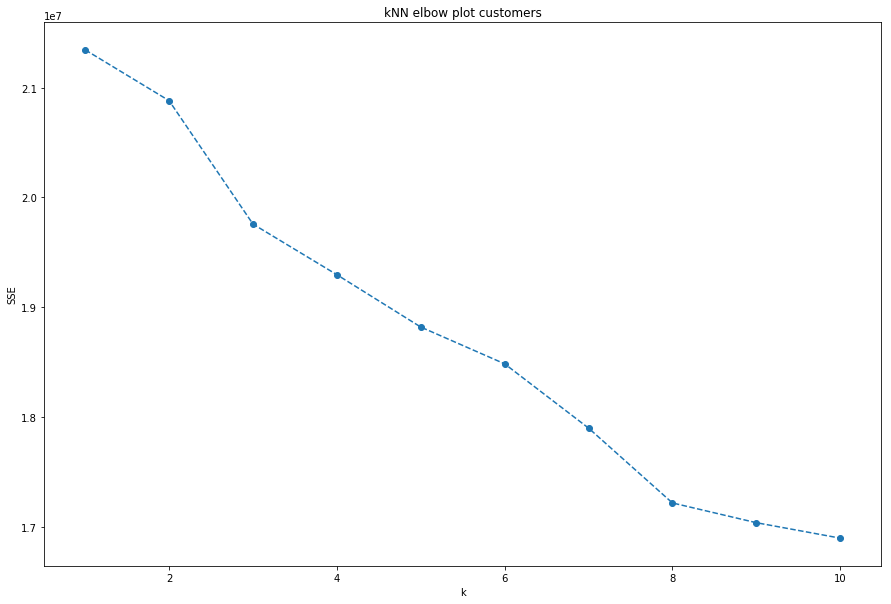

In [34]:
customers_cluster = customers_pca[:, 0:n_selected_components]

n_cluster = 10
clusters = np.arange(1, n_cluster+1)
sse = []

for k in clusters:
    kmeans = KMeans(n_clusters=k, random_state=0,  n_init = 1, max_iter=2).fit(customers_cluster)
    sse.append(kmeans.inertia_)

fig = plt.figure(figsize=(15,10))

plt.plot(clusters, sse, linestyle='--')
plt.scatter(clusters, sse)
plt.xlabel('k')
plt.ylabel('SSE')
plt.title('kNN elbow plot customers')
fig.savefig('knn_customers.png', bbox_inches='tight')

Now fit a knn clustering model with the selected k and the top components of the pca of the azdias dataset. Then predict the azdias and customers data set to this model and compare the culsters.

In [35]:
pca = PCA(n_components = 65)
pca.fit(azdias)

N_azdias, _ = azdias.shape
N_customers, _ = customers.shape

azdias_pca = pca.transform(azdias)
customers_pca = pca.transform(customers)
#customers_pca = pca.transform(customers.iloc[:, 0:429])

kmeans = KMeans(n_clusters=7, random_state=0).fit(azdias_pca)

azdias_kmeans = kmeans.predict(azdias_pca)
customers_kmeans = kmeans.predict(customers_pca)


_, cluster_size_azdias = np.unique(azdias_kmeans, return_counts=True)
_, cluster_size_customers = np.unique(customers_kmeans, return_counts=True)

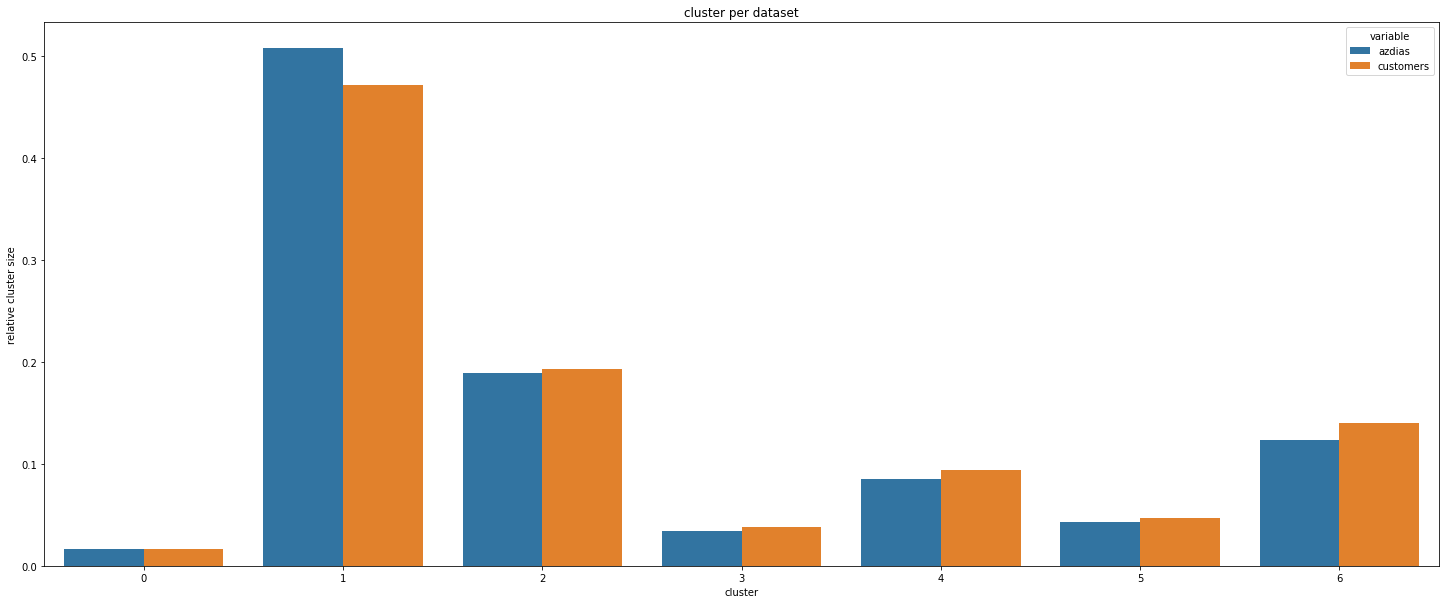

In [36]:
data = {'azdias': cluster_size_azdias / N_azdias,
       'customers': cluster_size_customers / N_customers,
       'cluster': np.arange(0,7)}
df_cluster = pd.DataFrame(data)
df_cluster = pd.melt(df_cluster, id_vars=['cluster'], value_vars=[ 'azdias', 'customers'])

fig = plt.figure(figsize=(25,10))
ax = sns.barplot(x="cluster", y="value", hue="variable", ci=None, data=df_cluster)
ax.set(xlabel='cluster', ylabel='relative cluster size')
ax.set_title("cluster per dataset")
fig.savefig('cluter_comparison.png', bbox_inches='tight')

Selecting the clusters that are the most equal an the most unequal.

In [37]:
data = {'cluster': np.arange(0,7),
        'azdias': cluster_size_azdias,
        'customers': cluster_size_customers}
df_cluster = pd.DataFrame(data)
df_cluster = df_cluster.assign(difference=df_cluster['azdias']-df_cluster['customers'])
df_cluster = df_cluster.assign(difference_relative = df_cluster['difference'] / (df_cluster['azdias']+df_cluster['customers']))
df_cluster = df_cluster.assign(difference_relative_abs = np.abs(df_cluster['difference_relative']))
df_cluster = df_cluster.sort_values(by='difference_relative_abs', ascending=False)
df_cluster

,cluster,azdias,customers,difference,difference_relative,difference_relative_abs
1,1,452526,90335,362191,0.667189,0.667189
0,0,15066,3139,11927,0.655150,0.655150
2,2,168812,36949,131863,0.640855,0.640855
5,5,38369,9023,29346,0.619218,0.619218
4,4,76083,17976,58107,0.617772,0.617772
3,3,30253,7333,22920,0.609802,0.609802
6,6,110112,26897,83215,0.607369,0.607369


In [38]:
cluster_to_inspect = df_cluster.iloc[[0,6], 0].values
cluster_to_inspect

array([1, 6])

Inspecting the components of the cluster that is the most equal. 

In [39]:
center = kmeans.cluster_centers_[cluster_to_inspect[0],:]
center.shape

N_components, N_features = pca.components_.shape

center.shape

data ={'PCA_weights': center,
      'Components': np.arange(0, N_components)}

df_components = pd.DataFrame(data)
df_components = df_components.assign(PCA_weights_absolute=np.abs(df_components['PCA_weights']))
df_components = df_components.sort_values(by=['PCA_weights'], ascending=False)


selected_components = df_components['Components'][0:2].values
selected_components


array([1, 2])

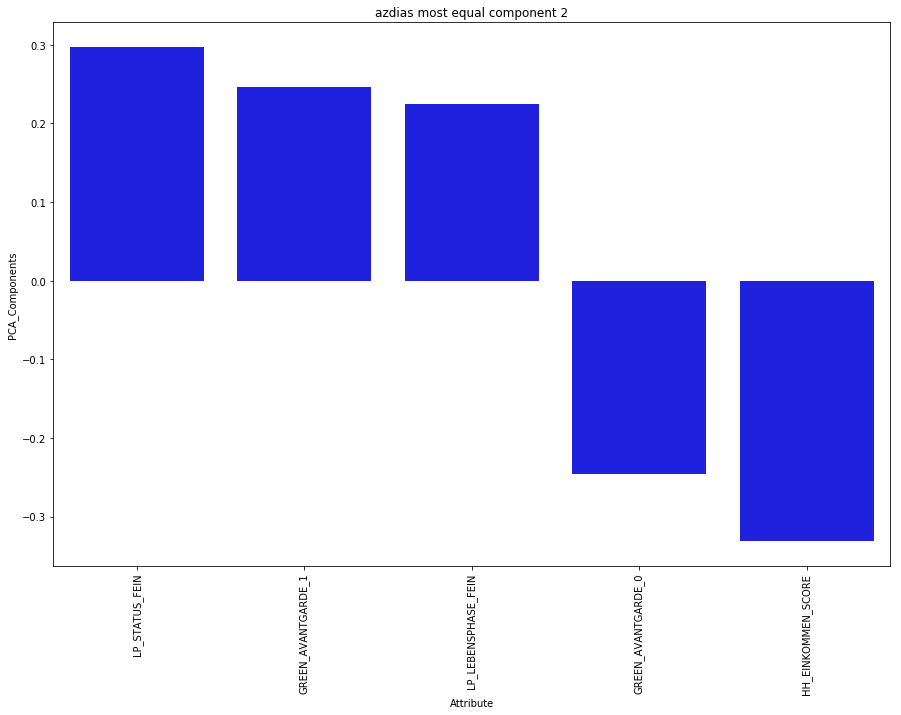

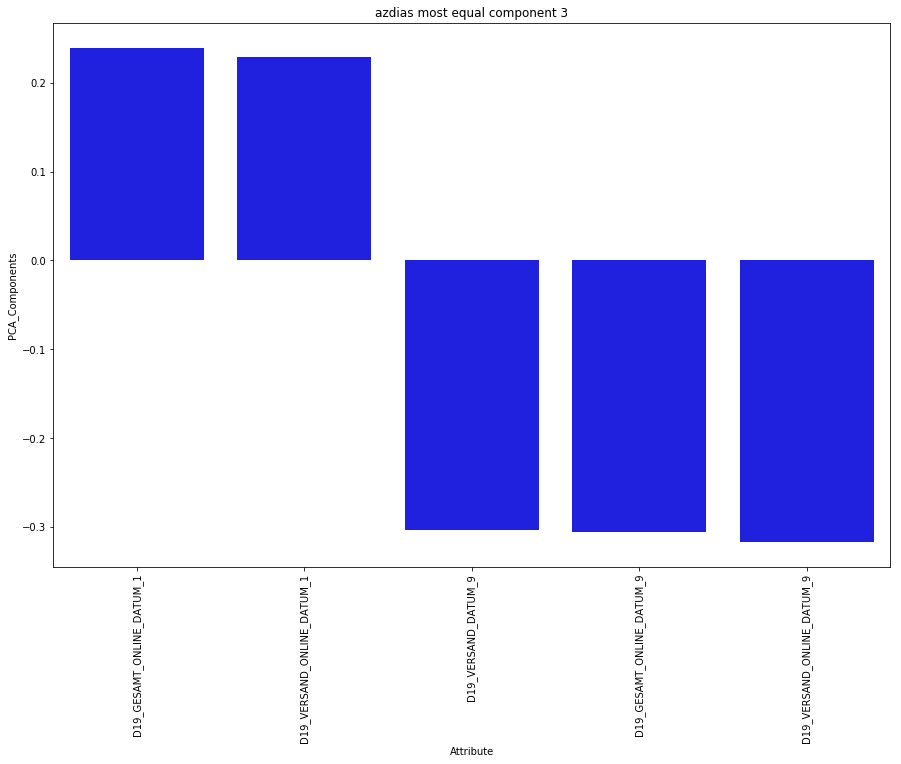

In [40]:
n_attributes = 5

attributes_most_common = []

for component in selected_components:
    df = plot_composition_pca(azdias, pca, component, "azdias most equal")
    attributes_most_common += list(df['Attribute'].values)

In [41]:
center = kmeans.cluster_centers_[cluster_to_inspect[1],:]
center.shape

N_components, N_features = pca.components_.shape

center.shape

data ={'PCA_weights': center,
      'Components': np.arange(0, N_components)}

df_components = pd.DataFrame(data)
df_components = df_components.assign(PCA_weights_absolute=np.abs(df_components['PCA_weights']))
df_components = df_components.sort_values(by=['PCA_weights'], ascending=False)

df_components


selected_components = df_components['Components'][0:2].values
selected_components


array([0, 3])

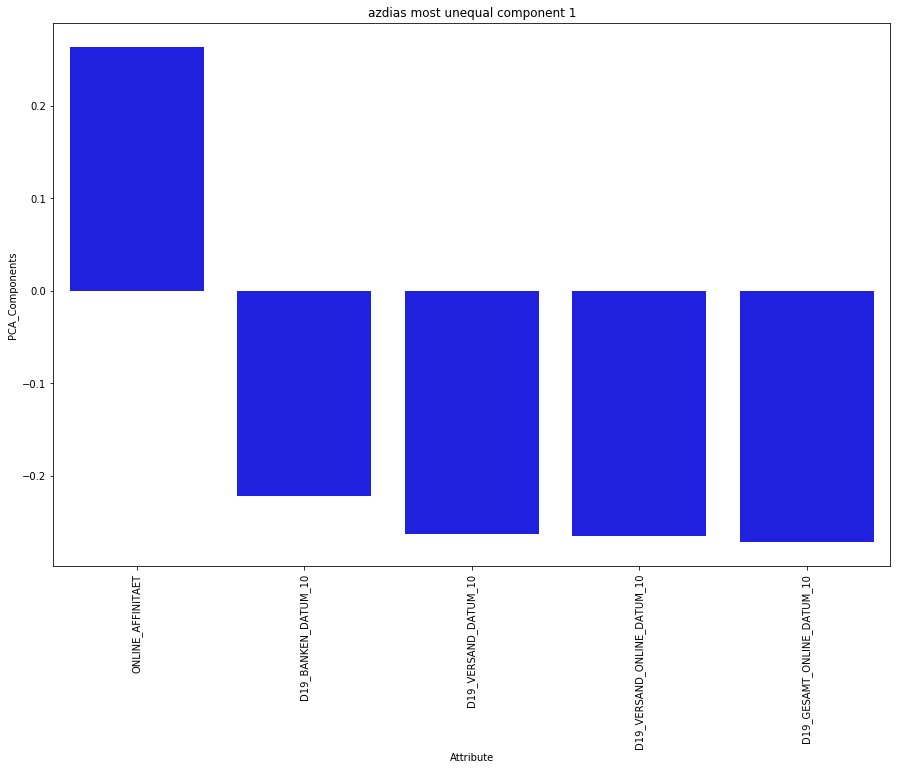

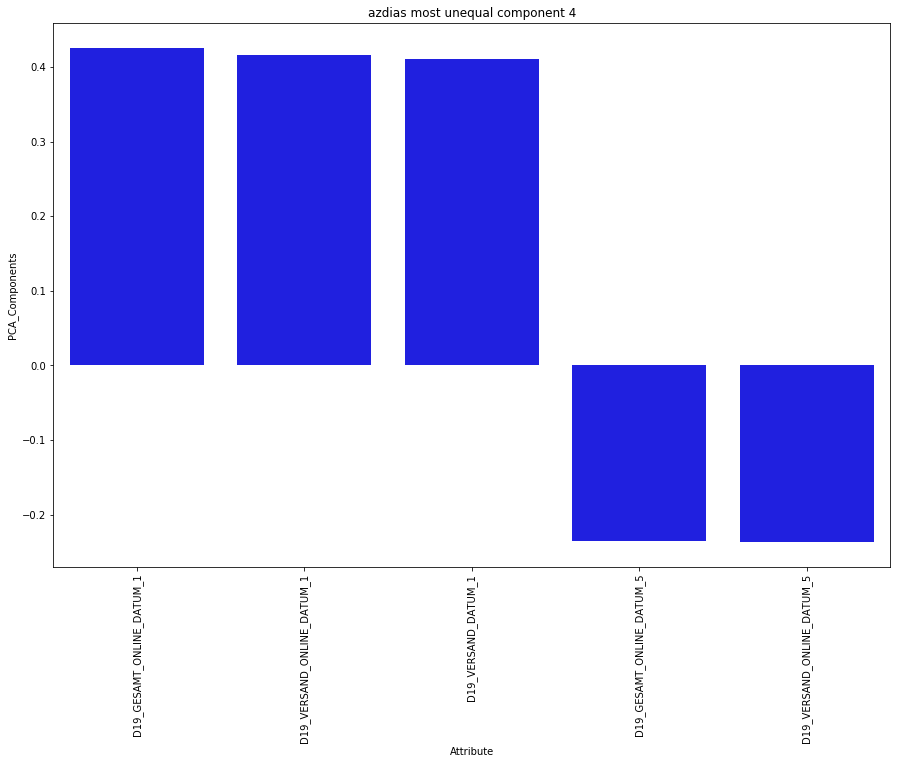

In [42]:
attributes_most_uncommon = []

for component in selected_components:
    df = plot_composition_pca(azdias, pca, component, "azdias most unequal")
    attributes_most_uncommon += list(df['Attribute'].values)

In [43]:
print(attributes_most_common)
print(attributes_most_uncommon)

print(set(attributes_most_common).intersection(set(attributes_most_uncommon)))

['LP_STATUS_FEIN', 'GREEN_AVANTGARDE_1', 'LP_LEBENSPHASE_FEIN', 'GREEN_AVANTGARDE_0', 'HH_EINKOMMEN_SCORE', 'D19_GESAMT_ONLINE_DATUM_1', 'D19_VERSAND_ONLINE_DATUM_1', 'D19_VERSAND_DATUM_9', 'D19_GESAMT_ONLINE_DATUM_9', 'D19_VERSAND_ONLINE_DATUM_9']
['ONLINE_AFFINITAET', 'D19_BANKEN_DATUM_10', 'D19_VERSAND_DATUM_10', 'D19_VERSAND_ONLINE_DATUM_10', 'D19_GESAMT_ONLINE_DATUM_10', 'D19_GESAMT_ONLINE_DATUM_1', 'D19_VERSAND_ONLINE_DATUM_1', 'D19_VERSAND_DATUM_1', 'D19_GESAMT_ONLINE_DATUM_5', 'D19_VERSAND_ONLINE_DATUM_5']
{'D19_VERSAND_ONLINE_DATUM_1', 'D19_GESAMT_ONLINE_DATUM_1'}


## Part 2: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

In [4]:
mailout_train = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TRAIN.csv', sep=';', low_memory=False)

In [5]:
mailout_train.shape

(42962, 367)

In [6]:
mailout_train.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,RESPONSE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,1763,2,1.0,8.0,NaN,NaN,NaN,NaN,8.0,15.0,...,5.0,2.0,1.0,6.0,9.0,3.0,3,0,2,4
1,1771,1,4.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,...,1.0,2.0,1.0,4.0,9.0,7.0,1,0,2,3
2,1776,1,1.0,9.0,NaN,NaN,NaN,NaN,7.0,0.0,...,6.0,4.0,2.0,NaN,9.0,2.0,3,0,1,4
3,1460,2,1.0,6.0,NaN,NaN,NaN,NaN,6.0,4.0,...,8.0,11.0,11.0,6.0,9.0,1.0,3,0,2,4
4,1783,2,1.0,9.0,NaN,NaN,NaN,NaN,9.0,53.0,...,2.0,2.0,1.0,6.0,9.0,3.0,3,0,1,3


The train data set has the same columns as the azdias data set and an additional traget column. I will save this in a variable and remove it along with the column LNR from the dataframe.

In [8]:
y = mailout_train['RESPONSE']
mailout_train.drop(['RESPONSE', 'LNR'], inplace = True, axis=1)

In [9]:
mailout_train.shape

(42962, 365)

Selecting only those variables that are containted in the DIAS Attributes file.

In [10]:
attributes_metdata = pd.read_excel('DIAS Attributes - Values 2017.xlsx')
attributes_metdata.drop(['Unnamed: 0'], axis = 1, inplace = True)
attributes_metdata.columns = ["Attribute", "Description", "Value", "Meaning"]

attributes_columns = {elem for elem in attributes_metdata['Attribute']}
columns_to_keep = mailout_train.columns.intersection(attributes_columns)
columns_to_keep = [elem for elem in columns_to_keep]

mailout_train = mailout_train[columns_to_keep]

mailout_train.shape

(42962, 272)

Now I want do extract the values with the meaning "unknown" or for example "no score calculated" from the DIAS Attributes file and set the corresponding values in the data frame to NaN.

In [11]:
attributes_metdata['Attribute'] = attributes_metdata['Attribute'].fillna(method='ffill')
mask =  ~attributes_metdata['Meaning'].isnull() & attributes_metdata['Meaning'].str.contains("unknown") 
attributes_metdata[mask]

df_missing = attributes_metdata[mask]
missing_dict = {}

for attr in df_missing['Attribute']:
    list_curr = []
    
    row = df_missing[df_missing['Attribute'] == attr]
    value = row['Value'].values[0]
    
    if type(value) is int:
        list_curr.append(value)
    else:       
        list_curr = [int(elem) for elem in value.split(',')]
        
    missing_dict[attr] = list_curr
    
for attr in mailout_train.columns:
    if attr in missing_dict.keys():
        mailout_train[attr].replace(missing_dict[attr], np.nan, inplace=True)

/opt/conda/lib/python3.6/site-packages/pandas/core/generic.py:5890: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


Investiogation of missing values.

In [13]:
N, p = mailout_train.shape
predictors_null = mailout_train.isnull().sum()
predictors_null_relative_mailout_train = predictors_null / N

df_missing = pd.DataFrame([predictors_null_relative_mailout_train]).T

df_missing.columns = ["mailout_train"]
df_missing['Attribute'] = df_missing.index
df_missing_plot = df_missing.sort_values(by=['mailout_train'], ascending=False)[0:15]
df_missing_plot = pd.melt(df_missing_plot, id_vars=['Attribute'], value_vars=[ 'mailout_train'])
df_missing_plot.head(n=20)

,Attribute,variable,value
0,TITEL_KZ,mailout_train,0.995042
1,KBA05_BAUMAX,mailout_train,0.534891
2,AGER_TYP,mailout_train,0.418114
3,ALTER_HH,mailout_train,0.306713
4,W_KEIT_KIND_HH,mailout_train,0.242470
5,REGIOTYP,mailout_train,0.231134
6,KKK,mailout_train,0.231134
7,KBA05_KRSAQUOT,mailout_train,0.210209
8,KBA05_KRSHERST1,mailout_train,0.210209
9,KBA05_KRSHERST2,mailout_train,0.210209


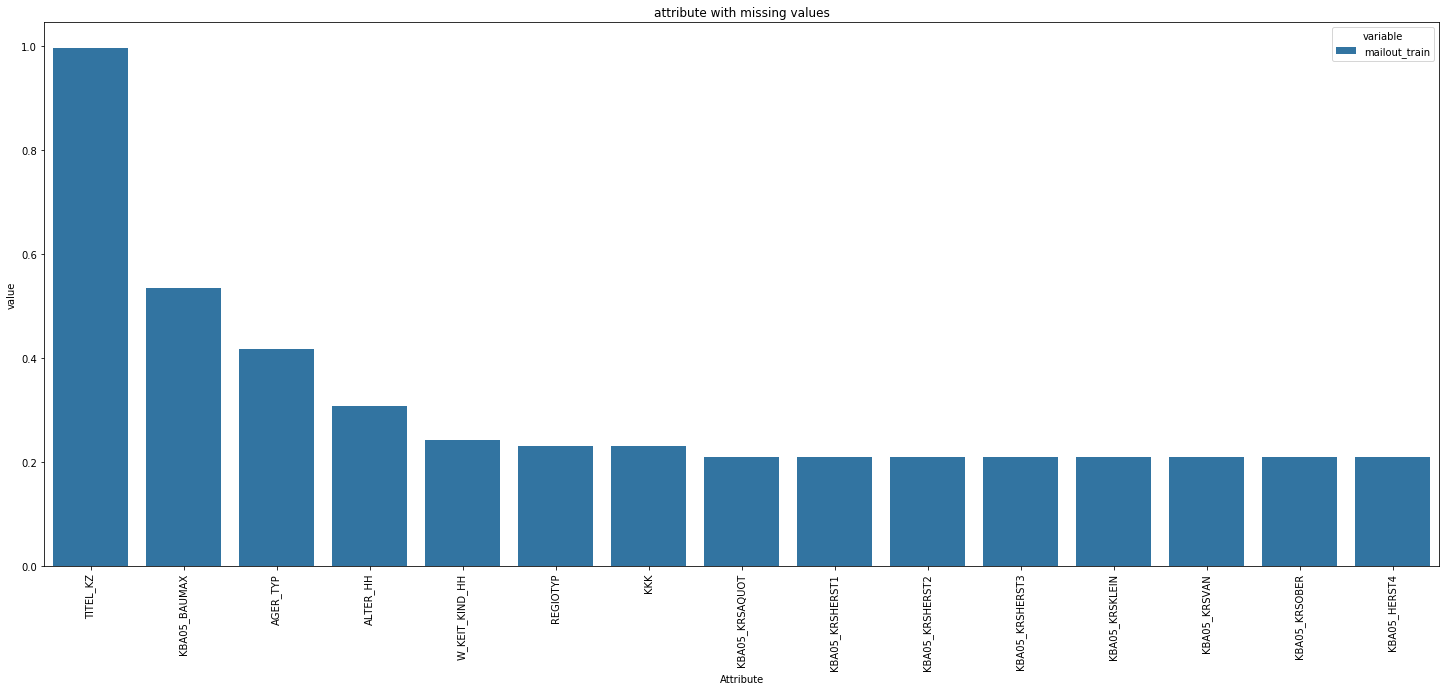

In [14]:
#sns.set(style="whitegrid")
fig = plt.figure(figsize=(25,10))
ax = sns.barplot(x="Attribute", y="value", hue="variable", ci=None, data=df_missing_plot)
plt.xticks(rotation=90)
ax.set_title("attribute with missing values")
fig.savefig('supervised_nas.png', bbox_inches='tight')

Selecting only those variables where the percentage of missing values is smaller than 23 %:

In [15]:
percentage_of_nas_lead_to_dropping = 0.23
df_missing = df_missing.sort_values(by=['mailout_train'], ascending=False)
predictors_to_keep = df_missing[df_missing['mailout_train'] < percentage_of_nas_lead_to_dropping].index
mailout_train = mailout_train[predictors_to_keep]

In [16]:
mailout_train.shape

(42962, 265)

Converting the categorial variables.

In [17]:
categorial_variables = ['AGER_TYP', 'ANREDE_KZ', 'BIP_FLAG', 'CAMEO_DEUG_2015', 'CAMEO_DEU_2015', 'CAMEO_DEUINTL_2015',
'CJT_GESAMTTYP', 'D19_BANKEN_DATUM', 'D19_BANKEN_DIREKT_RZ', 'D19_BANKEN_GROSS_RZ', 'D19_BANKEN_OFFLINE_DATUM',
'D19_BANKEN_ONLINE_DATUM', 'D19_BANKEN_REST_RZ', 'D19_BEKLEIDUNG_GEH_RZ', 'D19_BEKLEIDUNG_REST_RZ', 
'D19_BILDUNG_RZ', 'D19_BIO_OEKO_RZ', 'D19_BUCH_RZ', 'D19_DIGIT_SERV_RZ', 'D19_DROGERIEARTIKEL_RZ', 
'D19_ENERGIE_RZ', 'D19_FREIZEIT_RZ','D19_GARTEN_RZ',
'D19_GESAMT_DATUM,'
'D19_GESAMT_OFFLINE_DATUM',
'D19_GESAMT_ONLINE_DATUM',
'D19_HANDWERK_RZ',
'D19_HAUS_DEKO_RZ',
'D19_KINDERARTIKEL,RZ',
'D19_KONSUMTYP',
'D19_KK_KUNDENTYP',
'D19_KOSMETIK_RZ',
'D19_LEBENSMITTEL_RZ',
'D19_LOTTO_RZ',
'D19_NAHRUNGSERGAENZUNG_RZ',
'D19_RATGEBER_RZ',
'D19_REISEN_RZ',
'D19_SAMMELARTIKEL_RZ',
'D19_SCHUHE_RZ',
'D19_SONSTIGE_RZ',
'D19_TECHNIK_RZ',
'D19_TELKO_DATUM',
'D19_TELKO_MOBILE_RZ'
'D19_TELKO_OFFLINE_DATUM',
'D19_TELKO_ONLINE_DATUM',
'D19_TELKO_REST_RZ',
'D19_TIERARTIKEL_RZ',
'D19_VERSAND_DATUM',
'D19_VERSAND_OFFLINE_DATUM',
'D19_VERSAND_ONLINE_DATUM',
'D19_VERSAND_REST_RZ',
'D19_VERSICHERUNGEN_RZ',
'D19_VOLLSORTIMENT_RZ',
'D19_WEIN_FEINKOST_RZ',
'GEBAEUDETYP',
'GEBAEUDETYP_RASTER',
'GFK_URLAUBERTYP',
'GREEN_AVANTGARDE',
'HAUSHALTSSTRUKTUR',
'HEALTH_TYP',
'KBA05_HERSTTEMP'
'KBA05_MODTEMP',
'KBA05_MAXHERST',
'LP_FAMILIE_FEIN',
'LP_FAMILIE_GROB',
'NATIONALITAET_KZ',
'OST_WEST_KZ',
'SHOPPER_TYP',
'SOHO_FLAG',
'TITEL_KZ',
'VERS_TYP',
'ZABEOTYP']
    
for attr in mailout_train.columns:
    if attr in categorial_variables or (mailout_train.dtypes[attr] != 'float64' and mailout_train.dtypes[attr] != 'int64'):
        mailout_train[attr] = mailout_train[attr].astype('category')

Now i am done with the preprocessing steps regarding the whole dataset. Everthing that follows now, needs to be performed inside a cross validation loop.

In [18]:
df_category = mailout_train.select_dtypes(include='category')

imp_cat = SimpleImputer(strategy="most_frequent")
imp_cat.fit(df_category)

df_category = pd.DataFrame(imp_cat.transform(df_category), columns=df_category.columns)
df_category = df_category.astype('category')
df_category = pd.get_dummies(df_category)

df_float = mailout_train.select_dtypes(include=['float64', 'int64'])
#imp = KNNImputer(n_neighbors=5, weights="uniform")
imp_num = SimpleImputer(missing_values=np.nan, strategy='mean')
imp_num.fit(df_float)
df_float = pd.DataFrame(imp_num.transform(df_float), columns=df_float.columns)

mailout_train = pd.concat([df_category, df_float], axis=1)

In [19]:
scaler_mailout_train = StandardScaler()
scaler_mailout_train.fit(mailout_train)
mailout_train = pd.DataFrame(scaler_mailout_train.transform(mailout_train), columns=mailout_train.columns)

In [20]:
mailout_train.shape

(42962, 466)

Inspecting target - vanilla model

In [22]:
n_0 = len(y[y==0])
n_1 = len(y[y==1])

print('Number of 0: ', n_0)
print('Number of 1: ', n_1)

vanilla_acc = n_0 / (n_0 + n_1)
print(vanilla_acc)

Number of 0:  42430
Number of 1:  532
0.9876169638284996


Fitting decision tree

In [23]:
clf = DecisionTreeClassifier(random_state=0, max_depth=6, class_weight='balanced')
clf.fit(mailout_train.values, y.values)

y_pred = clf.predict(mailout_train.values)

In [24]:
from sklearn import metrics
metrics.accuracy_score(y.values, y_pred)

0.68190493924863838

Splitting test and train set

In [27]:
X = mailout_train.values
y = y.values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1, stratify = y)

In [28]:
n_0 = len(y_train[y_train==0])
n_1 = len(y_train[y_train==1])

print('Number of 0: ', n_0)
print('Number of 1: ', n_1)

vanilla_acc = n_0 / (n_0 + n_1)
print(vanilla_acc)

Number of 0:  31822
Number of 1:  399
0.9876167716706495


In [29]:
n_0 = len(y_test[y_test==0])
n_1 = len(y_test[y_test==1])

print('Number of 0: ', n_0)
print('Number of 1: ', n_1)

vanilla_acc = n_0 / (n_0 + n_1)
print(vanilla_acc)

Number of 0:  10608
Number of 1:  133
0.9876175402662695


Grid Search

In [31]:
data = {'AUC': [],
       'Model': []}
results = pd.DataFrame(data)

y_prob_best_clf_test = []
y_prob_best_clf_train = []

n_cv = 2

In [32]:
model = 'Logistic Regression'

grid = {'penalty': ['l2', 'none'],
        'class_weight': ['balanced'],
       'random_state': [0]}

clf = GridSearchCV(LogisticRegression(max_iter=150), grid, cv=n_cv, scoring = 'roc_auc')
clf.fit(X_train, y_train)


data = {'AUC': clf.best_score_,
       'Model': model}
results = results.append(data, ignore_index=True)

print(model)
print(clf.best_params_)

clf = clf.best_estimator_
clf.fit(X_train, y_train)

y_prob_best_clf_test.append(clf.predict_proba(X_test)[:,1])  
y_prob_best_clf_train.append(clf.predict_proba(X_train)[:,1]) 

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


Logistic Regression
{'class_weight': 'balanced', 'penalty': 'l2', 'random_state': 0}


/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [33]:
model = 'Random Forest'

grid = {'max_depth': [2, 4],
        'n_estimators': [50, 100],
        'class_weight': ['balanced'], 
        'random_state': [0]}

clf = GridSearchCV(RandomForestClassifier(), grid, cv=n_cv, scoring = 'roc_auc')
clf.fit(X_train, y_train)


data = {'AUC': clf.best_score_,
       'Model': model}
results = results.append(data, ignore_index=True)

print(model)
print(clf.best_params_)

clf = clf.best_estimator_
clf.fit(X_train, y_train)

y_prob_best_clf_test.append(clf.predict_proba(X_test)[:,1])  
y_prob_best_clf_train.append(clf.predict_proba(X_train)[:,1])  

Random Forest
{'class_weight': 'balanced', 'max_depth': 4, 'n_estimators': 50, 'random_state': 0}


In [34]:
model = 'Ada Boost'

grid = {'n_estimators': [50, 100],
        'learning_rate': [0.1, 0.8],
        'random_state': [0]}

clf = GridSearchCV(AdaBoostClassifier(), grid, cv=n_cv, scoring = 'roc_auc')
clf.fit(X_train, y_train)


data = {'AUC': clf.best_score_,
       'Model': model}
results = results.append(data, ignore_index=True)

print(model)
print(clf.best_params_)

clf = clf.best_estimator_
clf.fit(X_train, y_train)

y_prob_best_clf_test.append(clf.predict_proba(X_test)[:,1])  
y_prob_best_clf_train.append(clf.predict_proba(X_train)[:,1]) 

Ada Boost
{'learning_rate': 0.1, 'n_estimators': 100, 'random_state': 0}


In [38]:
model = 'GB'

grid = {'max_depth': [2, 4],
    'n_estimators': [50, 100],
    'subsample': [0.75, 1],
       'learning_rate': [0.1, 1],
        'random_state': [0]}

clf = GridSearchCV(GradientBoostingClassifier(), grid, cv=n_cv, scoring = 'roc_auc', n_jobs=1)
clf.fit(X_train, y_train)


data = {'AUC': clf.best_score_,
       'Model': model}
results = results.append(data, ignore_index=True)

print(model)
print(clf.best_params_)

clf = clf.best_estimator_
clf.fit(X_train, y_train)

y_prob_best_clf_test.append(clf.predict_proba(X_test)[:,1])  
y_prob_best_clf_train.append(clf.predict_proba(X_train)[:,1])

GB
{'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 100, 'random_state': 0, 'subsample': 0.75}


In [39]:
results.sort_values(by='AUC', ascending=False).head()

,AUC,Model
3,0.613211,GB
1,0.588766,Random Forest
2,0.588482,Ada Boost
0,0.565261,Logistic Regression


Calibration plot

In [40]:
n_bins = 10

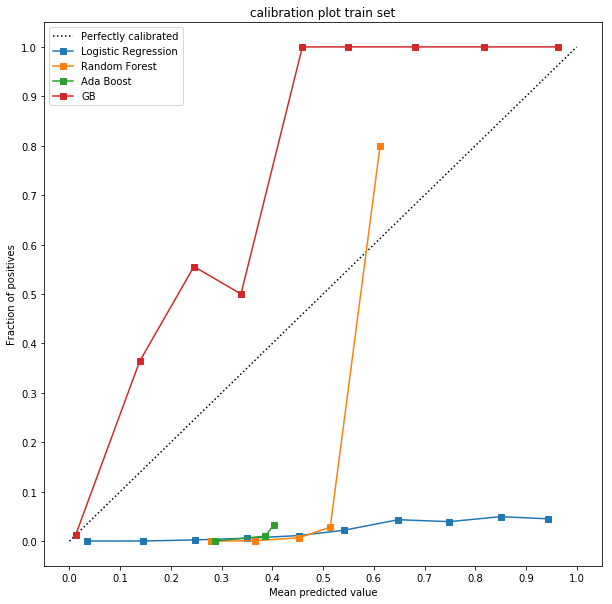

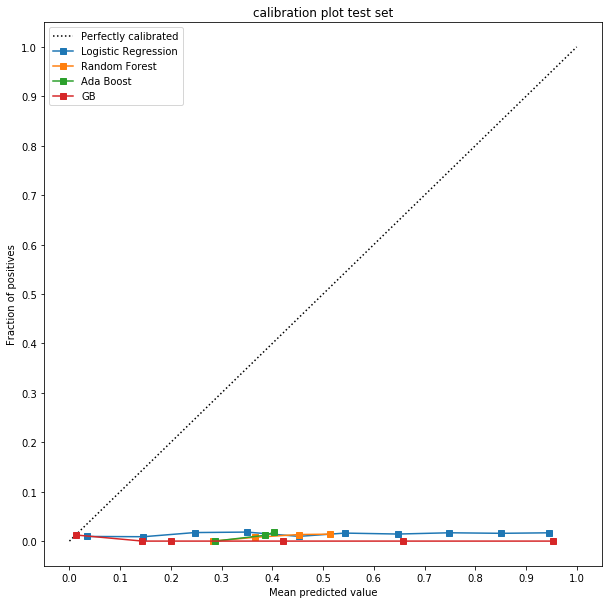

In [41]:
fig = plt.figure(figsize=(10, 10))

plt.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")


for i in range(len(y_prob_best_clf_train)):
    fraction_of_positives, mean_predicted_value = calibration_curve(y_train, y_prob_best_clf_train[i], n_bins=n_bins)
    name = results.iloc[i]['Model']
    
    plt.plot(mean_predicted_value, fraction_of_positives, "s-",
                 label="%s" % (name, ))

plt.xlim(-0.05, 1.05)
plt.xticks(np.arange(0, 1.1, step=0.1))
plt.yticks(np.arange(0, 1.1, step=0.1))

plt.xlabel('Mean predicted value')
plt.ylabel('Fraction of positives')
plt.title('calibration plot train set')
plt.legend(loc="upper left")
fig.savefig('calib_train.png', bbox_inches='tight')



fig = plt.figure(figsize=(10, 10))

plt.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")


for i in range(len(y_prob_best_clf_test)):
    fraction_of_positives, mean_predicted_value = calibration_curve(y_test, y_prob_best_clf_test[i], n_bins=n_bins)
    name = results.iloc[i]['Model']
    
    plt.plot(mean_predicted_value, fraction_of_positives, "s-",
                 label="%s" % (name, ))

plt.xlim(-0.05, 1.05)
plt.xticks(np.arange(0, 1.1, step=0.1))
plt.yticks(np.arange(0, 1.1, step=0.1))

plt.xlabel('Mean predicted value')
plt.ylabel('Fraction of positives')
plt.title('calibration plot test set')
plt.legend(loc="upper left")
fig.savefig('calib_test.png', bbox_inches='tight')

## Part 3: Kaggle Competition

Now that you've created a model to predict which individuals are most likely to respond to a mailout campaign, it's time to test that model in competition through Kaggle. If you click on the link [here](http://www.kaggle.com/t/21e6d45d4c574c7fa2d868f0e8c83140), you'll be taken to the competition page where, if you have a Kaggle account, you can enter. If you're one of the top performers, you may have the chance to be contacted by a hiring manager from Arvato or Bertelsmann for an interview!

Your entry to the competition should be a CSV file with two columns. The first column should be a copy of "LNR", which acts as an ID number for each individual in the "TEST" partition. The second column, "RESPONSE", should be some measure of how likely each individual became a customer – this might not be a straightforward probability. As you should have found in Part 2, there is a large output class imbalance, where most individuals did not respond to the mailout. Thus, predicting individual classes and using accuracy does not seem to be an appropriate performance evaluation method. Instead, the competition will be using AUC to evaluate performance. The exact values of the "RESPONSE" column do not matter as much: only that the higher values try to capture as many of the actual customers as possible, early in the ROC curve sweep.

In [43]:
mailout_test = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TEST.csv', sep=';', low_memory=False)

Getting ids for the result.

In [44]:
LNR = mailout_test['LNR']

Performing the preprocessing as in part 2. Note that i use the transformers that where fittet with the training set.

In [45]:
try:
    mailout_test.drop(['LNR', 'Unnamed: 0'], inplace = True, axis=1)
    mailout_test = mailout_test[columns_to_keep]
    mailout_test = mailout_test[predictors_to_keep]

    for attr in mailout_test.columns:
        if attr in categorial_variables or (mailout_test.dtypes[attr] != 'float64' and mailout_test.dtypes[attr] != 'int64'):
            mailout_test[attr] = mailout_test[attr].astype('category')

    df_category = mailout_test.select_dtypes(include='category')


    df_category = pd.DataFrame(imp_cat.transform(df_category), columns=df_category.columns)
    df_category = df_category.astype('category')
    df_category = pd.get_dummies(df_category)


    df_float = mailout_test.select_dtypes(include=['float64', 'int64'])


    df_float = pd.DataFrame(imp_num.transform(df_float), columns=df_float.columns)
    mailout_test = pd.concat([df_category, df_float], axis=1)

    mailout_test = pd.DataFrame(scaler_mailout_train.transform(mailout_test), columns=mailout_test.columns)
except Exception as e:
    print(e)

"['Unnamed: 0'] not found in axis"


I run into an error, because in the test set there are new values of some cateogrial variables. As all valid values of the variables are stated in the DIAS Attriutes files, it is valied to include the occourances already in the train set. I wil refit the train sets scalers and them transform the test set respectivly.

In [56]:
#train set
mailout_train = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TRAIN.csv',
                          sep=';', low_memory=False)
y = mailout_train['RESPONSE']

mailout_train.drop(['LNR', 'RESPONSE'], inplace = True, axis=1)
mailout_train = mailout_train[columns_to_keep]
mailout_train = mailout_train[predictors_to_keep]

for attr in mailout_train.columns:
    if attr in categorial_variables or (mailout_train.dtypes[attr] != 'float64' and mailout_train.dtypes[attr] != 'int64'):
        mailout_train[attr] = mailout_train[attr].astype('category')

df_category_train = mailout_train.select_dtypes(include='category')
df_float_train = mailout_train.select_dtypes(include=['float64', 'int64'])
N, _ = df_category_train.shape

# test set
mailout_test = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TEST.csv',
                            sep=';', low_memory=False)

mailout_test.drop(['LNR'], inplace = True, axis=1)
mailout_test = mailout_test[columns_to_keep]
mailout_test = mailout_test[predictors_to_keep]

for attr in mailout_test.columns:
    if attr in categorial_variables or (mailout_test.dtypes[attr] != 'float64' and mailout_test.dtypes[attr] != 'int64'):
        mailout_test[attr] = mailout_test[attr].astype('category')

df_category_test = mailout_test.select_dtypes(include='category')
df_float_test = mailout_test.select_dtypes(include=['float64', 'int64'])


# imputing floats
imp_num = SimpleImputer(missing_values=np.nan, strategy='mean')
imp_num.fit(df_float_train)
df_float_train = pd.DataFrame(imp_num.transform(df_float_train), columns=df_float_train.columns)
df_float_test = pd.DataFrame(imp_num.transform(df_float_test), columns=df_float_test.columns)


# imputing categories
df_category_whole = df_category_train.append(df_category_test)

imp_cat = SimpleImputer(strategy="most_frequent")
imp_cat.fit(df_category_whole)

df_category_whole = pd.DataFrame(imp_cat.transform(df_category_whole), columns=df_category_whole.columns)
df_category_whole = df_category_whole.astype('category')

df_category_train = df_category_whole[0:N]
df_category_test = df_category_whole[N:]



# dummies

print("category")
print(df_category_train.shape)
print(df_category_test.shape)

print("float")
print(df_float_train.shape)
print(df_float_test.shape)



df_category_train = pd.get_dummies(df_category_train)
df_category_test = pd.get_dummies(df_category_test)


mailout_train = pd.concat([df_category_train.reset_index(drop=True), df_float_train], axis=1)
mailout_test = pd.concat([df_category_test.reset_index(drop=True), df_float_test], axis=1)



print('whole')
print(mailout_train.shape)
print(mailout_test.shape)


print(mailout_train.isnull().sum().sum())
print(mailout_test.isnull().sum().sum())


category
(42962, 27)
(42833, 27)
float
(42962, 238)
(42833, 238)
whole
(42962, 471)
(42833, 471)
0
0


Fitting the best model with the whole trainig data and predict the test set. Creating the final data frame with the column LNR and saving it as a csv file to upload it to kaggle.

In [57]:
X = mailout_train.values

X_test = mailout_test.values

clf = GradientBoostingClassifier(max_depth = 2, n_estimators = 100, subsample = 0.75, learning_rate = 0.1, random_state = 0)
clf.fit(X, y.values)

y_probabilites = clf.predict_proba(X_test)[:,1]


final = pd.DataFrame({'LNR': LNR.astype(np.int32), 'RESPONSE':y_probabilites})
final.to_csv('final.csv', index = False)
final.head()

,LNR,RESPONSE
0,1754,0.016944
1,1770,0.017887
2,1465,0.006979
3,1470,0.004261
4,1478,0.009082
